<a href="https://colab.research.google.com/github/GursimarSaini/INSE6220Project/blob/master/OccupancyDetectionPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycaret==2.3.6

In [ ]:
!pip install pca

In [ ]:
!pip install shap

### Import of Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import statsmodels
import shap
#import pycaret as pc

from pca import pca
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pycaret.classification import *

sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (13,8)

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


### Getting Data

The study collects the data using a microcontroller. It was linked to a ZigBee radio, which was used to relay the data to a recording station. A digital camera was utilised to assess whether or not the room was inhabited. Every minute, the camera time stamped an image, which was then manually examined to identify the data. The humidity ratio is another additional variable in the data model, calculated as ( W = 0.622*(pw/(p-pw)) ).

The data was collected in February in Mons, Belgium, during the winter. The room was heated by hot water radiators, which kept the temperature above 19 degrees Celsius. The models are tested for data sets with the office door open and closed in order to estimate the difference in occupancy detection accuracy provided by the models. The measurements were obtained at 14-second intervals/3-4 times every minute, and then averaged for that minute.

Attribute Information is as follows:

1. date time year-month-day hour:minute:second
2. Temperature, in Celsius
3. Relative Humidity, %
4. Light, in Lux
5. CO2, in ppm
6. Humidity Ratio, Derived quantity from temperature and relative humidity, in kgwater-vapor/kg-air
7. Occupancy, 0 or 1, 0 for not occupied, 1 for occupied status

In [8]:
df = pd.read_csv('https://raw.githubusercontent.com/GursimarSaini/INSE6220Project/master/datasets/occupancy/datatraining.csv')
#df=df.head(5000)
#df['date'] = df['date'].str.slice(start=11)
#df['date'] = df['date'].apply(lambda x: timeToNum(x))
df=df.drop(columns=["id","date"])

In [6]:
df.head(5)

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,23.18,27.2720,426.0,721.25,0.004793,1
1,23.15,27.2675,429.5,714.00,0.004783,1
2,23.15,27.2450,426.0,713.50,0.004779,1
3,23.15,27.2000,426.0,708.25,0.004772,1
4,23.10,27.2000,426.0,704.50,0.004757,1


In [7]:
df.info()
print("Number of duplicated rows is: ", df.duplicated().sum())
print("Number of rows with NaNs is: ", df.isna().any(axis=1).sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8143 entries, 0 to 8142
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Temperature    8143 non-null   float64
 1   Humidity       8143 non-null   float64
 2   Light          8143 non-null   float64
 3   CO2            8143 non-null   float64
 4   HumidityRatio  8143 non-null   float64
 5   Occupancy      8143 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 381.8 KB
Number of duplicated rows is:  867
Number of rows with NaNs is:  0


### Exploratory Data Analysis

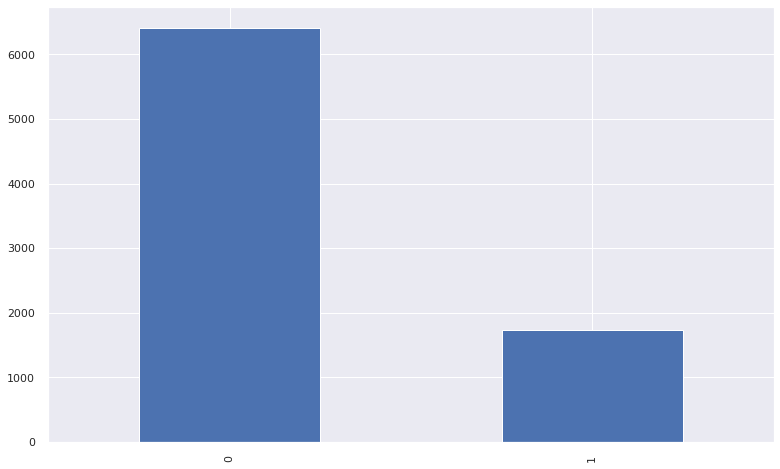

In [8]:
df['Occupancy'].value_counts().plot(kind='bar')
plt.ylabel('')
plt.show()

##### Extracting Attribute Matrix

In [9]:
X = df.drop(columns=['Occupancy'])
X.head(5)

,Temperature,Humidity,Light,CO2,HumidityRatio
0,23.18,27.2720,426.0,721.25,0.004793
1,23.15,27.2675,429.5,714.00,0.004783
2,23.15,27.2450,426.0,713.50,0.004779
3,23.15,27.2000,426.0,708.25,0.004772
4,23.10,27.2000,426.0,704.50,0.004757


##### Original Data

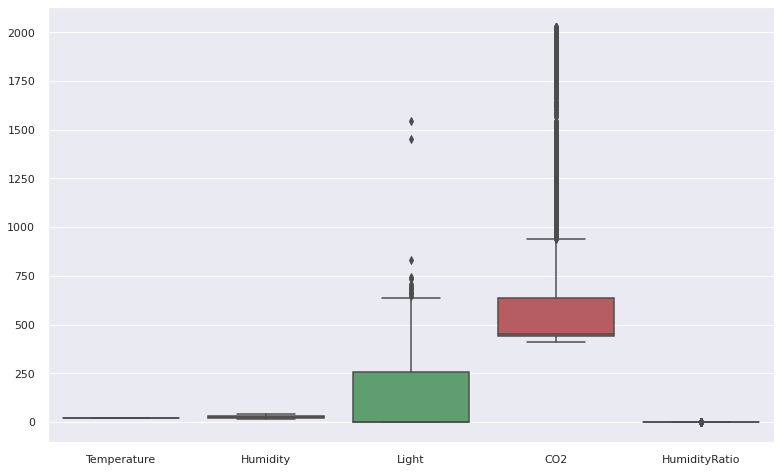

In [10]:
sns.boxplot(data=X)

##### Standardized Data

In [11]:
# Generates a Standardized matrix with mean zero and variance is 1

Xs = StandardScaler().fit_transform(X)  
Xcols = X.columns
X = pd.DataFrame(Xs)
X.columns = Xcols
X.head(5)

,Temperature,Humidity,Light,CO2,HumidityRatio
0,2.518470,0.278526,1.573763,0.364948,1.091757
1,2.488967,0.277713,1.591735,0.341881,1.080555
2,2.488967,0.273645,1.573763,0.340290,1.075888
3,2.488967,0.265508,1.573763,0.323587,1.066555
4,2.439796,0.265508,1.573763,0.311655,1.049523


In [12]:
X.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio
count,8.143000e+03,8.143000e+03,8.143000e+03,8.143000e+03,8.143000e+03
mean,-4.874742e-15,-2.317630e-15,-2.207112e-15,4.259695e-16,1.718221e-15
std,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00
min,-1.592248e+00,-1.624791e+00,-6.137261e-01,-6.165933e-01,-1.394355e+00
25%,-9.038502e-01,-1.000115e+00,-6.137261e-01,-5.330748e-01,-9.201475e-01
50%,-2.252867e-01,8.877312e-02,-6.137261e-01,-4.869407e-01,-7.243751e-02
75%,7.581387e-01,8.681862e-01,7.027469e-01,1.027265e-01,5.742528e-01
max,2.518470e+00,2.420232e+00,7.326619e+00,4.524170e+00,3.066492e+00


##### Box and Whisker Plots

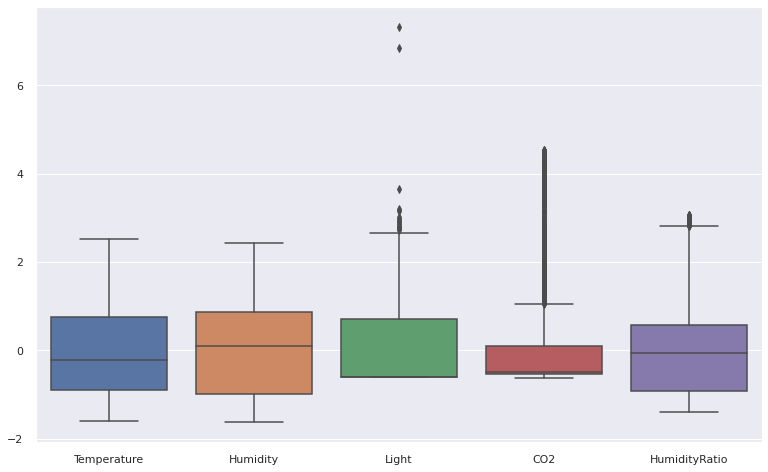

In [13]:
sns.boxplot(data=X)

##### Correlation Matrix

(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text major ticklabel objects>)

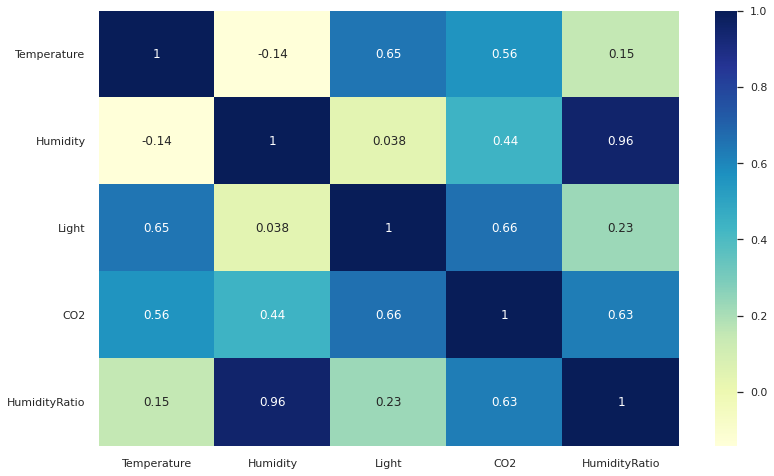

In [14]:
sns.heatmap(X.corr(), cmap='YlGnBu', annot=True)
plt.yticks(rotation=0)

##### Pair Plot

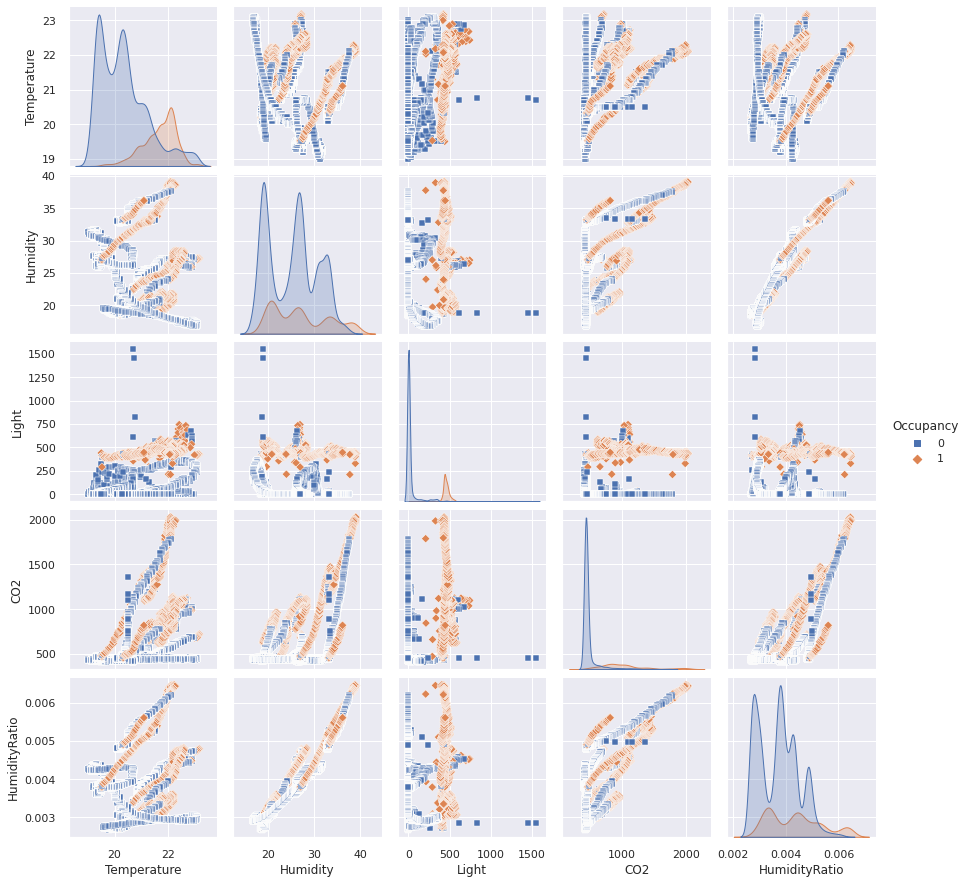

In [15]:
sns.pairplot(df, hue='Occupancy', markers=["s", "D"], kind="scatter")
plt.show()

### Principal Component Analysis

##### Covariance

In [16]:
cova = np.cov(X.transpose())
covaMatrix = pd.DataFrame(cova)
covaMatrix.head(15)

,0,1,2,3,4
0,1.000123,-0.141777,0.650022,0.559963,0.151780
1,-0.141777,1.000123,0.037833,0.439077,0.955315
2,0.650022,0.037833,1.000123,0.664104,0.230449
3,0.559963,0.439077,0.664104,1.000123,0.626633
4,0.151780,0.955315,0.230449,0.626633,1.000123


In [17]:
pcss = PCA()
pcss.fit_transform(X)
A = pcss.components_.T 
Lambda = pcss.explained_variance_ 

##### Eigenvalues and Eigenvectors

In [18]:
print(f'Eigenvectors:\n{A}')
print(f'Eigenvalues:\n{Lambda}')

Eigenvectors:
[[ 0.34385624  0.5358643  -0.71337364  0.22538247 -0.18685057]
 [ 0.39566375 -0.57411081  0.00924853  0.22696629 -0.67988804]
 [ 0.41414891  0.44461199  0.66542367  0.43317687  0.01923538]
 [ 0.55006986  0.12010568  0.11093843 -0.81726459 -0.05262155]
 [ 0.50111567 -0.41369197 -0.18951653  0.2052448   0.70689468]]
Eigenvalues:
[2.73685981e+00 1.69967935e+00 3.48872139e-01 2.14393433e-01
 8.09358836e-04]


In [19]:
model = pca()
# Fit transform
out = model.fit_transform(X)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [5] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [3] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [5] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


In [20]:
# Top features in signifacnt PCs
out['topfeat']

,PC,feature,loading,type
0,PC1,CO2,0.550070,best
1,PC2,Humidity,-0.574111,best
2,PC3,Temperature,-0.713374,best
3,PC3,Light,0.665424,weak
4,PC1,HumidityRatio,0.501116,weak


##### PCs

In [21]:
out['PC']

,PC1,PC2,PC3
0,2.375810,1.481548,-0.913234
1,2.354485,1.476060,-0.880672
2,2.342218,1.472145,-0.891961
3,2.325134,1.478671,-0.892121
4,2.293128,1.457935,-0.855139
...,...,...,...
8138,2.879268,-0.897206,0.468321
8139,2.866476,-0.877949,0.472498
8140,2.925637,-0.874514,0.433447
8141,2.990828,-0.895826,0.435690


In [22]:
A = out['loadings'].T
print(A)

                    PC1       PC2       PC3
Temperature    0.343856  0.535864 -0.713374
Humidity       0.395664 -0.574111  0.009249
Light          0.414149  0.444612  0.665424
CO2            0.550070  0.120106  0.110938
HumidityRatio  0.501116 -0.413692 -0.189517


##### Scree Plot

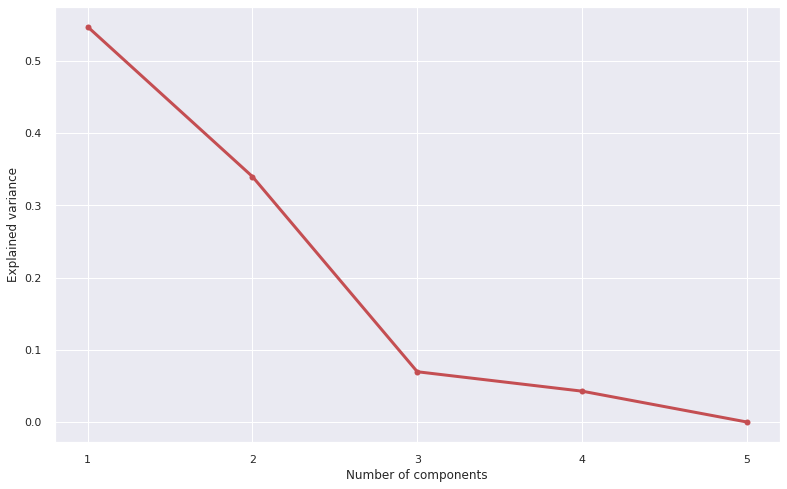

In [23]:
VR = out['variance_ratio']
x = np.arange(len(VR)) + 1
plt.plot(x, VR, 'ro-', lw=3)
plt.xticks(x, [""+str(i) for i in x], rotation=0)
plt.xlabel('Number of components')
plt.ylabel('Explained variance') 
plt.show()

##### Explained Variance

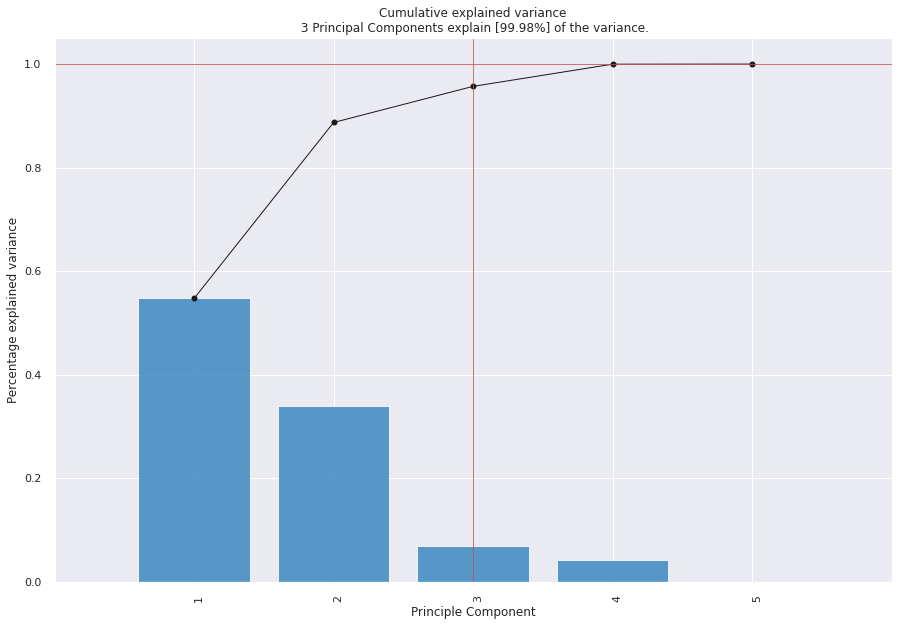

<Figure size 936x576 with 0 Axes>

In [24]:
model.plot();

##### PC Coefficient Plot

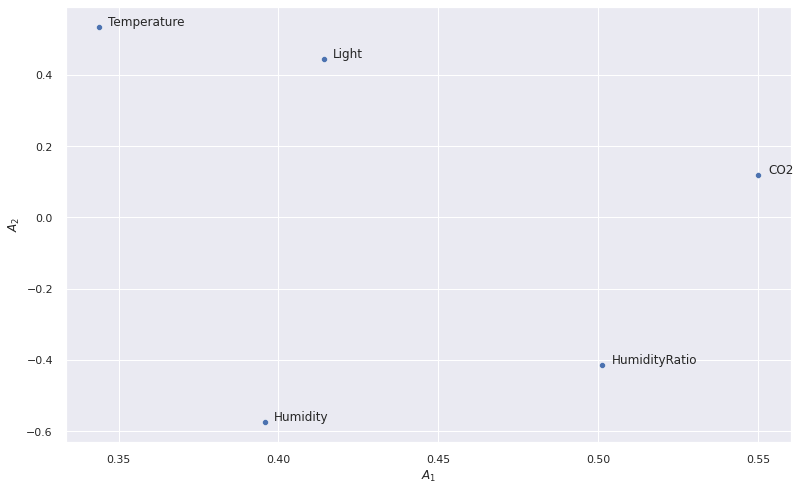

In [25]:
variables = list(df.columns)
sns.scatterplot(data=A, x="PC1", y="PC2")
plt.xlabel('$A_1$')
plt.ylabel('$A_2$')
for i in range(A.shape[0]):
     plt.text(x=A.PC1[i]+0.003,y=A.PC2[i]+0.003, s=variables[i])

##### BiPlot

[pca] >Plot PC1 vs PC2 with loadings.
[pca] >Set parameter "label=None" to ignore the labels and significanly speed up the scatter plot.


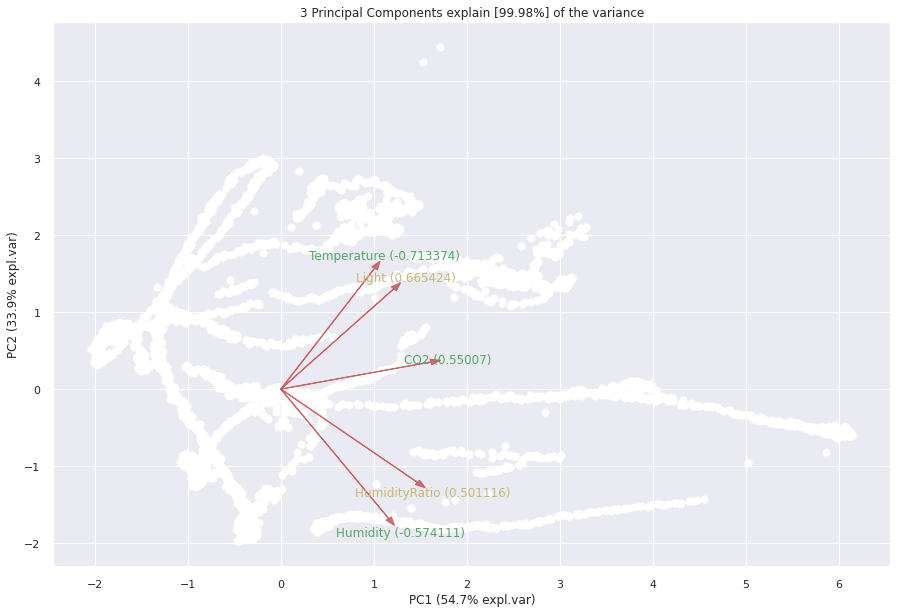

(<Figure size 1080x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f23d3feacd0>)

In [26]:
model.biplot(label=False, legend=False, cmap=None)

[pca] >Plot PC1 vs PC2 vs PC3 with loadings.
[pca] >Set parameter "label=None" to ignore the labels and significanly speed up the scatter plot.


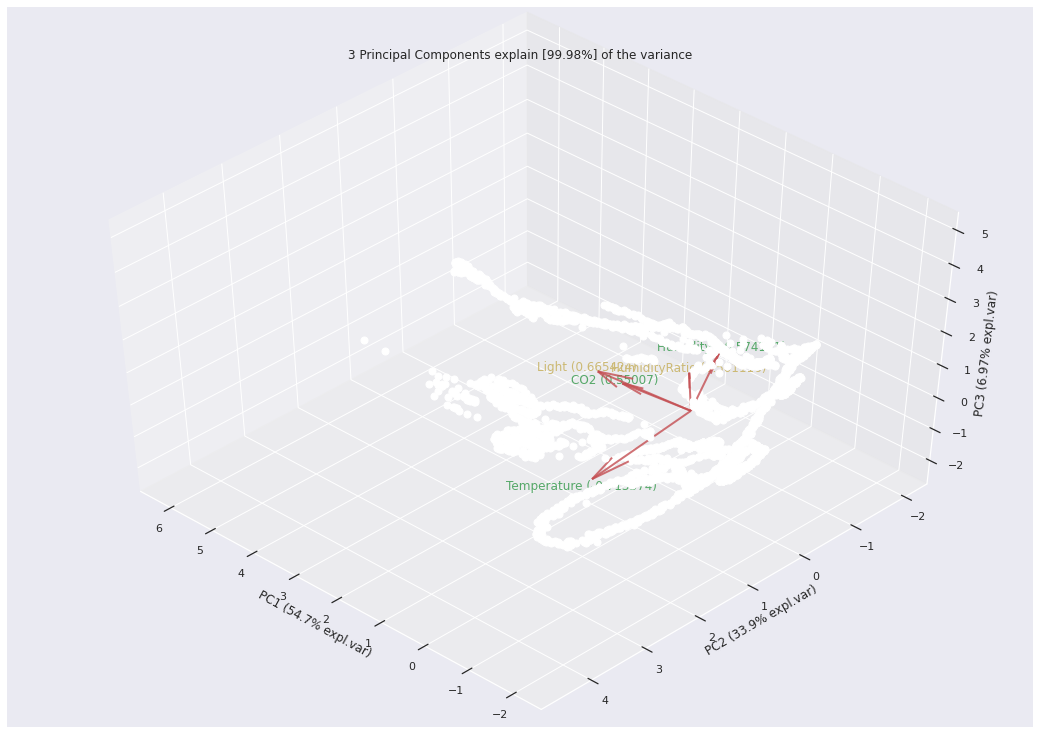

(<Figure size 1080x720 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x7f23cd688390>)

In [27]:
model.biplot3d(label=False, legend=False, cmap=None)

### Classification

In [5]:
from pycaret.utils import enable_colab 
enable_colab()

Colab mode enabled.


In [10]:
data = df
data.reset_index(drop=True, inplace=True)
print('Data for Modeling: ' + str(data.shape))

Data for Modeling: (8143, 6)


In [20]:
clf = setup(data=data, target='Occupancy', train_size=0.7, session_id=666)

,Description,Value
0,session_id,666
1,Target,Occupancy
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(8143, 6)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [31]:
best_model = compare_models()
best_model

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9954,0.9994,0.9918,0.9870,0.9894,0.9865,0.9865,0.514
rf,Random Forest Classifier,0.9942,0.9993,0.9893,0.9838,0.9865,0.9828,0.9829,0.665
lightgbm,Light Gradient Boosting Machine,0.9942,0.9991,0.9902,0.9830,0.9865,0.9828,0.9829,0.137
dt,Decision Tree Classifier,0.9930,0.9893,0.9828,0.9844,0.9835,0.9791,0.9791,0.021
ada,Ada Boost Classifier,0.9926,0.9989,0.9893,0.9766,0.9829,0.9782,0.9782,0.224
gbc,Gradient Boosting Classifier,0.9921,0.9987,0.9852,0.9781,0.9816,0.9766,0.9766,0.492
qda,Quadratic Discriminant Analysis,0.9886,0.9942,0.9959,0.9531,0.9740,0.9667,0.9671,0.019
knn,K Neighbors Classifier,0.9884,0.9971,0.9934,0.9546,0.9736,0.9661,0.9665,0.131
ridge,Ridge Classifier,0.9877,0.0000,0.9992,0.9468,0.9722,0.9643,0.9650,0.016
lda,Linear Discriminant Analysis,0.9875,0.9931,0.9992,0.9460,0.9718,0.9638,0.9644,0.022


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=666, verbose=0,
                     warm_start=False)

##### Classifiers

From the above provided results, we select these as our candidate models:
- Extra Trees Classifier
- Light Gradient Boosting Machine
- Random Forest Classifier
- Decision Trees Classifier

##### Extra Trees Classifier

In [21]:
et = create_model('et')
tunedET = tune_model(et)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9860,0.9946,0.9917,0.9449,0.9677,0.9588,0.9592
1,0.9947,0.9973,1.0000,0.9760,0.9879,0.9845,0.9846
2,0.9807,0.9916,0.9918,0.9237,0.9565,0.9441,0.9451
3,0.9912,0.9965,1.0000,0.9606,0.9799,0.9743,0.9746
4,0.9930,0.9974,1.0000,0.9683,0.9839,0.9794,0.9796
5,0.9877,0.9916,1.0000,0.9457,0.9721,0.9642,0.9649
6,0.9860,0.9942,0.9836,0.9524,0.9677,0.9588,0.9590
7,0.9860,0.9935,1.0000,0.9385,0.9683,0.9593,0.9601
8,0.9877,0.9959,1.0000,0.9457,0.9721,0.9642,0.9649
9,0.9912,0.9973,0.9836,0.9756,0.9796,0.9740,0.9740


In [22]:
evaluate_model(tunedET)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

##### Light Gradient Boosting Machine

In [23]:
lightgbm = create_model('lightgbm')
tunedLightgbm = tune_model(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9947,0.9999,0.9835,0.9917,0.9876,0.9842,0.9842
1,0.9982,1.0000,1.0000,0.9919,0.9959,0.9948,0.9948
2,0.9895,0.9993,0.9836,0.9677,0.9756,0.9689,0.9690
3,0.9895,0.9997,0.9836,0.9677,0.9756,0.9689,0.9690
4,0.9930,0.9998,0.9836,0.9836,0.9836,0.9791,0.9791
5,0.9912,0.9981,0.9836,0.9756,0.9796,0.9740,0.9740
6,0.9947,0.9997,0.9918,0.9837,0.9878,0.9844,0.9844
7,0.9965,0.9999,1.0000,0.9839,0.9919,0.9896,0.9897
8,0.9965,0.9998,1.0000,0.9839,0.9919,0.9896,0.9897
9,0.9947,0.9996,0.9836,0.9917,0.9877,0.9843,0.9843


In [24]:
evaluate_model(tunedLightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

##### Random Forest Classifiers

In [25]:
rf = create_model('rf')
tunedRF = tune_model(rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9965,0.9999,1.0000,0.9837,0.9918,0.9896,0.9896
1,0.9965,1.0000,1.0000,0.9839,0.9919,0.9896,0.9897
2,0.9860,0.9995,0.9918,0.9453,0.9680,0.9590,0.9595
3,0.9895,0.9993,0.9918,0.9603,0.9758,0.9691,0.9693
4,0.9912,0.9985,0.9918,0.9680,0.9798,0.9742,0.9743
5,0.9825,0.9957,0.9754,0.9444,0.9597,0.9485,0.9487
6,0.9912,0.9998,1.0000,0.9606,0.9799,0.9743,0.9746
7,0.9947,0.9999,1.0000,0.9760,0.9879,0.9845,0.9846
8,0.9947,0.9997,1.0000,0.9760,0.9879,0.9845,0.9846
9,0.9947,0.9956,0.9836,0.9917,0.9877,0.9843,0.9843


In [26]:
evaluate_model(tunedRF)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

##### Decision Trees Classifier

In [27]:
dt = create_model('dt')
tunedDT = tune_model(dt)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9912,0.9916,0.9669,0.9915,0.9791,0.9735,0.9737
1,0.9982,0.9990,1.0000,0.9919,0.9959,0.9948,0.9948
2,0.9930,0.9958,0.9918,0.9758,0.9837,0.9793,0.9793
3,0.9912,0.9933,0.9836,0.9756,0.9796,0.9740,0.9740
4,0.9930,0.9979,0.9836,0.9836,0.9836,0.9791,0.9791
5,0.9877,0.9886,0.9754,0.9675,0.9714,0.9636,0.9636
6,0.9947,0.9909,0.9918,0.9837,0.9878,0.9844,0.9844
7,0.9912,0.9906,0.9836,0.9756,0.9796,0.9740,0.9740
8,0.9947,0.9990,1.0000,0.9760,0.9879,0.9845,0.9846
9,0.9895,0.9949,0.9590,0.9915,0.9750,0.9683,0.9686


In [28]:
evaluate_model(tunedDT)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

### Classification+PCA

In [11]:
clfPCA = setup(data=data, target='Occupancy', train_size=0.7, session_id=666, normalize = True, pca = True, pca_components = 3)

,Description,Value
0,session_id,666
1,Target,Occupancy
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(8143, 6)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [41]:
bestModelPCA = compare_models()
bestModelPCA

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9951,0.9997,0.9926,0.9846,0.9886,0.9854,0.9855,0.512
lightgbm,Light Gradient Boosting Machine,0.9933,0.9994,0.9877,0.9814,0.9845,0.9802,0.9803,0.095
rf,Random Forest Classifier,0.9926,0.9995,0.9901,0.9758,0.9829,0.9782,0.9783,0.663
knn,K Neighbors Classifier,0.9919,0.9983,0.9852,0.9774,0.9812,0.9761,0.9762,0.125
dt,Decision Tree Classifier,0.9909,0.9864,0.9787,0.9788,0.9786,0.9728,0.9729,0.021
gbc,Gradient Boosting Classifier,0.9900,0.9989,0.9869,0.9672,0.9769,0.9705,0.9706,0.513
ridge,Ridge Classifier,0.9886,0.0000,0.9992,0.9503,0.9741,0.9668,0.9673,0.016
lda,Linear Discriminant Analysis,0.9886,0.9943,0.9992,0.9503,0.9741,0.9668,0.9673,0.019
ada,Ada Boost Classifier,0.9875,0.9968,0.9910,0.9529,0.9715,0.9635,0.9639,0.227
svm,SVM - Linear Kernel,0.9868,0.0000,0.9910,0.9499,0.9700,0.9615,0.9620,0.020


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=666, verbose=0,
                     warm_start=False)

##### Extra Trees Classifier on PCA model

In [12]:
etP = create_model('et')
tunedETp = tune_model(etP)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9877,0.9991,1.0000,0.9453,0.9719,0.9640,0.9647
1,0.9947,0.9987,1.0000,0.9760,0.9879,0.9845,0.9846
2,0.9807,0.9980,0.9918,0.9237,0.9565,0.9441,0.9451
3,0.9912,0.9980,1.0000,0.9606,0.9799,0.9743,0.9746
4,0.9895,0.9995,1.0000,0.9531,0.9760,0.9693,0.9697
5,0.9842,0.9961,0.9918,0.9380,0.9641,0.9540,0.9546
6,0.9895,0.9990,1.0000,0.9531,0.9760,0.9693,0.9697
7,0.9860,0.9984,1.0000,0.9385,0.9683,0.9593,0.9601
8,0.9860,0.9986,1.0000,0.9385,0.9683,0.9593,0.9601
9,0.9947,0.9982,1.0000,0.9760,0.9879,0.9845,0.9846


In [13]:
evaluate_model(tunedETp)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

##### Light Gradient Boosting Machine on PCA model

In [14]:
lightgbmP = create_model('lightgbm')
tunedLightgbmP = tune_model(lightgbmP)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9877,0.9994,0.9669,0.9750,0.9710,0.9632,0.9632
1,0.9965,0.9998,1.0000,0.9839,0.9919,0.9896,0.9897
2,0.9877,0.9978,0.9918,0.9528,0.9719,0.9640,0.9644
3,0.9947,0.9997,0.9918,0.9837,0.9878,0.9844,0.9844
4,0.9965,0.9998,1.0000,0.9839,0.9919,0.9896,0.9897
5,0.9877,0.9962,0.9836,0.9600,0.9717,0.9638,0.9639
6,0.9947,0.9999,0.9836,0.9917,0.9877,0.9843,0.9843
7,0.9860,0.9981,0.9754,0.9597,0.9675,0.9585,0.9586
8,0.9930,0.9997,0.9918,0.9758,0.9837,0.9793,0.9793
9,0.9912,0.9997,0.9672,0.9916,0.9793,0.9737,0.9738


In [15]:
evaluate_model(tunedLightgbmP)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

##### Random Trees Classifier on PCA model

In [16]:
rfP = create_model('rf')
tunedRFp = tune_model(rfP)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9912,0.9979,0.9917,0.9677,0.9796,0.9740,0.9741
1,0.9947,0.9999,1.0000,0.9760,0.9879,0.9845,0.9846
2,0.9825,0.9983,0.9918,0.9308,0.9603,0.9491,0.9499
3,0.9860,0.9980,0.9836,0.9524,0.9677,0.9588,0.9590
4,0.9930,0.9997,1.0000,0.9683,0.9839,0.9794,0.9796
5,0.9842,0.9971,0.9918,0.9380,0.9641,0.9540,0.9546
6,0.9895,0.9994,1.0000,0.9531,0.9760,0.9693,0.9697
7,0.9912,0.9994,1.0000,0.9606,0.9799,0.9743,0.9746
8,0.9860,0.9998,1.0000,0.9385,0.9683,0.9593,0.9601
9,0.9930,0.9995,1.0000,0.9683,0.9839,0.9794,0.9796


In [17]:
evaluate_model(tunedRFp)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

##### Decision Trees Classifier on PCA model

In [18]:
dtP = create_model('dt')
tunedDTp = tune_model(dtP)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9842,0.9931,0.9421,0.9828,0.9620,0.9521,0.9524
1,0.9947,0.9997,0.9918,0.9837,0.9878,0.9844,0.9844
2,0.9842,0.9884,0.9672,0.9593,0.9633,0.9532,0.9532
3,0.9825,0.9882,0.9590,0.9590,0.9590,0.9479,0.9479
4,0.9930,0.9977,1.0000,0.9683,0.9839,0.9794,0.9796
5,0.9842,0.9904,0.9836,0.9449,0.9639,0.9538,0.9541
6,0.9860,0.9902,0.9918,0.9453,0.9680,0.9590,0.9595
7,0.9877,0.9989,0.9590,0.9832,0.9710,0.9632,0.9633
8,0.9930,0.9996,0.9836,0.9836,0.9836,0.9791,0.9791
9,0.9947,0.9995,1.0000,0.9760,0.9879,0.9845,0.9846


In [19]:
evaluate_model(tunedDTp)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

### Explainable AI with Shapley values

##### SHAP summary plot

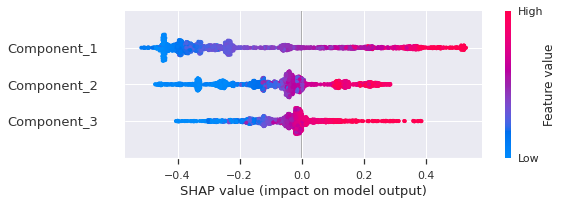

In [50]:
interpret_model(tunedETp, plot='summary')

##### Visualizing Predictions

In [51]:
interpret_model(tunedETp, plot='reason')